In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

The process of calibrating an image consists of mainly 3 steps: 1) find chessboard-corners in a dataset of images containing a chessboard. 2) Use the corner points to compute a camera matrix. 3) Use the camera matrix to undistort images.

In [88]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 0.01)
"""
Implement the number of vertical and horizontal corners
nb_vertical = ...
nb_horizontal = ...
"""
nb_vertical = 5
nb_horizontal = 7
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32)
objp[:,:2] = np.mgrid[0:nb_vertical,0:nb_horizontal].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('raw_videos/final_project/calib/image_02/data/*.png')
assert images


for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    """
    Implement findChessboardCorners here
    ret, corners = ...
    """
    ret, corners = cv2.findChessboardCorners(gray, (nb_vertical,nb_horizontal), None)
    
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray, corners, (7, 7), (-1, -1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nb_vertical,nb_horizontal), corners2,ret)
        cv2.imshow('img',img)
        cv2.waitKey(1000)

cv2.destroyAllWindows()

Using the extracted corners we can obtain a camera matrix that contains the information needed to undistort images

In [89]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
img = cv2.imread('raw_videos/final_project/calib/image_02/data/0000000014.png')
h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

The last step is to actually undistort an image:

Text(0.5, 1.0, 'Undistorted image')

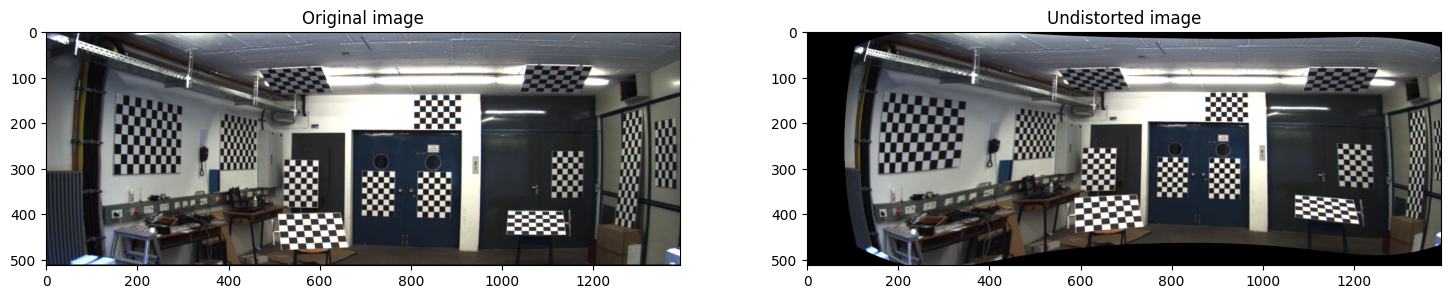

In [90]:
# undistort
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax[0].imshow(img[...,[2,1,0]])
ax[0].set_title('Original image')
ax[1].imshow(dst[...,[2,1,0]])
ax[1].set_title('Undistorted image')

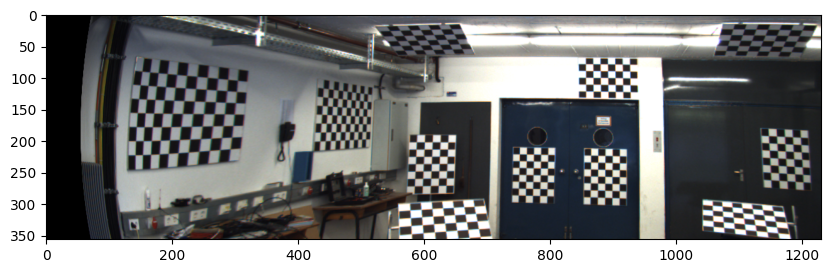

In [91]:
# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]
plt.figure(figsize=(10,10))
plt.imshow(dst[...,[2,1,0]])

In [92]:
path = glob.glob('results/coef.yml')
""" Save the camera matrix and the distortion coefficients to given path/file. """
cv_file = cv2.FileStorage('coef.yml', cv2.FILE_STORAGE_WRITE)
cv_file.write("K", mtx)
cv_file.write("D", dist)
# note you *release* you don't close() a FileStorage object
cv_file.release()